In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn import tree
from sklearn.grid_search import GridSearchCV

/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [3]:
file = 'new_CF DataForML- OCT2018.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History_1')

In [87]:
col_names= ['Created Time', 'Delivered Time','Total Orders to Assign', 'Qty', 'Customer Code']
df.dropna(subset=col_names, how='any', inplace = True)
df['Hours2deliver']= df.apply(get_time, c1='Created Time', c2='Delivered Time', axis=1)
df['LocationCode'], levels = pd.factorize(df['Location Code'])
df['BikerCode'], levels = pd.factorize(df['Biker Code'])
df['CustomerCode'], levels = pd.factorize(df['Customer Code'])

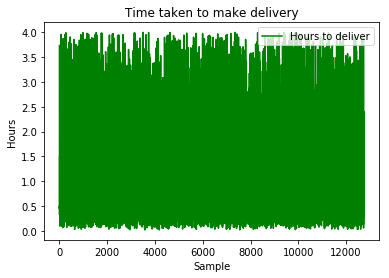

In [34]:
is_strange =  df['Hours2deliver']>4
df= df[~is_strange]
plt.plot(df['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()
plt.show()

In [94]:
from sklearn.metrics import make_scorer
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(5, 20), 'min_samples_split':np.arange(30, 45)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=10, n_jobs=4, refit=True, scoring=scoring,verbose=1)

In [95]:
#grid_search = tree.DecisionTreeRegressor(criterion='mae', random_state=0, max_depth=19, min_samples_split=45)
grid_search.fit(X_trn,Y_trn)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 1788 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 2250 out of 2250 | elapsed:   33.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_split': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [96]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'max_depth': 10, 'min_samples_split': 44}
[0.09448728 0.37189075 0.41522418 0.1183978 ]


In [97]:
#predict_model = trained_model.predict(X_tst)
predict_model = grid_search.best_estimator_.predict(X_tst)

<H2> Convert time in to 2 dimension (sine and cosine) because of cyclic nature of time <H2>

In [59]:
#sorted_df = df.sort_values(by=['Created Time'])
created_week, created_day, df['created_time'] = zip(*[(d.dayofweek, d.date().day, 
                                                 d.date()) for d in df['Created Time']])
#sorted_df = sorted_df.assign(created_week=created_week, created_day=created_day, created_time=created_time)

In [61]:
df['diff'] = df['Created Time'] - df['created_time'].apply(pd.to_datetime)

In [62]:
df['seconds'] = df['diff'].dt.total_seconds()

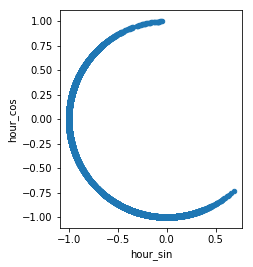

In [63]:
df['hour_sin'] = np.sin(2 * np.pi * df['seconds']/86400.0)
df['hour_cos'] = np.cos(2 * np.pi * df['seconds']/86400.0)
df.plot.scatter('hour_sin','hour_cos').set_aspect('equal');

In [100]:
X = df[['seconds', 'LocationCode', 'CustomerCode', ]].values
Y = df['Hours2deliver'].values
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.1, random_state=42)

In [89]:
tree_regression_model = tree.DecisionTreeRegressor(max_depth=10, min_samples_split=44, random_state=0)
trained_model = tree_regression_model.fit(X_trn, Y_trn)

In [90]:
predict_model = trained_model.predict(X_tst)

In [98]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model,)
print(mse)
print('r2')
r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.6102638292853008
r2
0.23012082541012213


0.22769600911220123

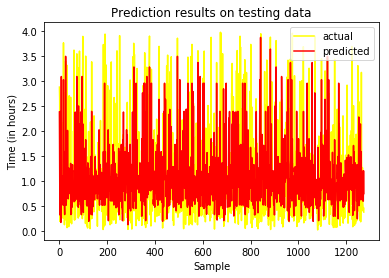

In [99]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

In [49]:
total_seconds=60*60*24
sine_sec = np.abs((np.arcsin(predict_model[:,0]))*(total_seconds/2*np.pi))

In [50]:
cosine_sec = np.abs((np.arcsin(predict_model[:,1]))*(total_seconds/2*np.pi))

In [51]:
sine_autal_sec = np.abs((np.arcsin(Y_tst[:,0]))*(total_seconds/2*np.pi))

In [52]:
cosine_autal_sec = np.abs((np.arcsin(Y_tst[:,1]))*(total_seconds/2*np.pi))

In [53]:
df1 = pd.DataFrame()
df1['sine_sec'] = sine_sec
df1['sine_autal_sec'] = sine_autal_sec
df1['cosine_sec'] = cosine_sec
df1['cosine_autal_sec'] = cosine_autal_sec

In [54]:
df1.to_csv('model1_time_comparison.csv', sep=',', index=False)

In [55]:
df1.head(10)

,sine_sec,sine_autal_sec,cosine_sec,cosine_autal_sec
0,36310.945660,27703.969684,165171.541849,185479.485379
1,127968.913866,154656.710835,81510.507625,58526.744229
2,92039.159321,100334.388472,108602.268303,112849.066592
3,98899.808681,118208.251912,2716.616496,94975.203152
4,92039.159321,167733.916927,108602.268303,45449.538137
5,100735.845151,62060.062604,86341.415742,151123.392459
6,100735.845151,71238.794697,86341.415742,141944.660366
7,134068.088617,188854.870345,66784.471729,24328.584718
8,64175.902559,194697.686020,132765.912041,18485.769043
9,20667.693711,31553.125270,183250.128871,181630.329793


In [128]:
import datetime
str(datetime.timedelta(seconds=25406))

'7:03:26'

In [129]:
str(datetime.timedelta(seconds=2793.098046))

'0:46:33.098046'

In [101]:
str(datetime.timedelta(seconds=93005.77080))

'1 day, 1:50:05.770800'

In [125]:
str(datetime.timedelta(seconds=58996))

'16:23:16'

In [108]:
np.sum(sine_sec>86400)

996

In [109]:
np.sum(sine_autal_sec>86400)

953

In [110]:
np.sum(cosine_autal_sec>86400)

622

In [111]:
np.sum(cosine_sec>86400)

551

In [126]:
test = df['del_seconds'].values

In [132]:
np.sum(test < 800)

0

In [57]:
np.sin(3.34265)

-0.19970548942551575